[*********************100%***********************]  1 of 1 completed


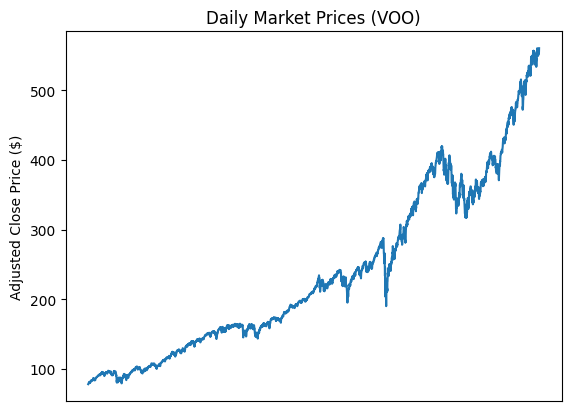

In [5]:
from lbm.datasets.voo import Preprocessor
from matplotlib import pyplot as plt

processor = Preprocessor()
train_loder, val_loader, test_loader = processor.get_loaders()

prices = processor.dataset.x
plt.plot(prices)
plt.title("Daily Market Prices (VOO)")
# turn off labels on x-axis
plt.ylabel("Adjusted Close Price ($)")
plt.xticks([])
plt.show()

In [ ]:
from lbm.models import PriceForecaster